In [6]:
import litebird_sim as lbs
from litebird_sim import RotQuaternion
import astropy
from typing import Union

# Abstract Base Class (discendente da classe "ScanningStrategy") che definisce una nuova strategia di scansione
class SimpleScanningStrategy(lbs.ScanningStrategy):
    def generate_spin2ecl_quaternions( # unico metodo obbligatorio
        self,
        start_time: Union[float, astropy.time.Time], # ora di inizio
        time_span_s: float, # durata simulazione
        delta_time_s: float, # intervallo di tempo da utilizzare tra quaternioni consecutivi
    ) -> RotQuaternion:
        # Calcola quanti quaternioni sono necessari per coprire l'intervallo di tempo specificato dal "time_span_s"
        num_of_quaternions = (
            lbs.ScanningStrategy.optimal_num_of_quaternions(
                time_span_s=time_span_s,
                delta_time_s=delta_time_s,
            )
        )

        
        # Fa una room per i quaternioni
        spin2ecliptic_quats = np.empty((num_of_quaternions, 4))

        
        # Calcola i tempi in cui i quaternioni hanno bisogno di essere calcolati
        # Nota: ScanningStrategy restituisce 2 arrays ("time" and "time_s"), ma trascuriamo il secondo perchè non ne abbiamo bisogno in questo semplice caso
        (time, _) = lbs.ScanningStrategy.get_times(
            start_time=start_time,
            delta_time_s=delta_time_s,
            num_of_quaternions=num_of_quaternions,
        )

        
        # Calcola l'angolo nel piano dell'Eclittica tra l'asse x e l'asse Sole-Terra 
        sun_earth_angles_rad = (
            lbs.calculate_sun_earth_angles_rad(time)
        )

        # Questo codice non è ottimizzato: in un caso reale si usa Numba anzichè il seguente loop con "for" 
        for i in range(num_of_quaternions):
            # Ruota di 90° attorno all'asse y (muove il boresight nel piano Eclittico xy)
            spin2ecliptic_quats[i, :] = lbs.quat_rotation_y(np.pi / 2)

            # Simula la rivoluzione dello spacecraft intorno al Sole usando gli angoli calcolati sopra
            lbs.quat_left_multiply(
                spin2ecliptic_quats[i, :],
                *lbs.quat_rotation_z(sun_earth_angles_rad[i]),
            )

        # Restituisce i quaternioni avvolti in una istanza di "RotQuaternion"
        return lbs.RotQuaternion(
            start_time=start_time,
            sampling_rate_hz=1.0 / delta_time_s,
            quats=spin2ecliptic_quats,
        )

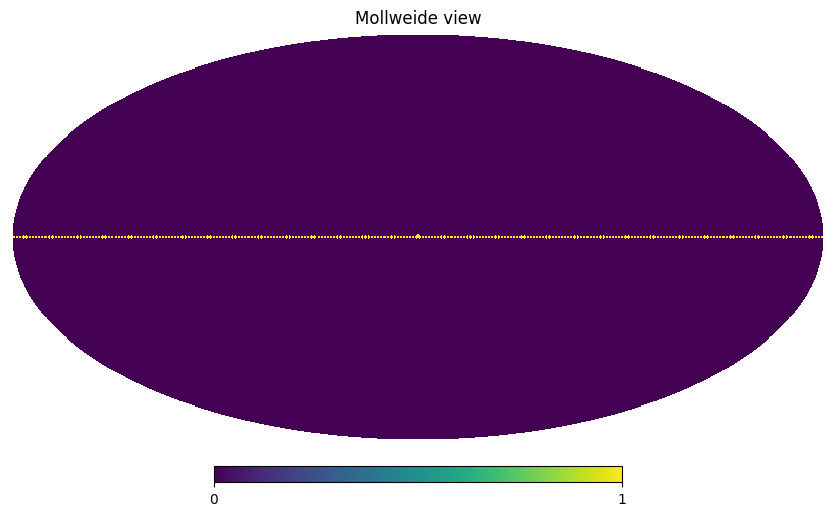

In [7]:
import astropy.units as u
import healpy
import numpy as np

sim = lbs.Simulation(
    start_time=0,
    duration_s=(365 * u.day).to("s").value, # durata di 365 giorni (altrimenti non si vede cambiamento nella direzione di puntamento)
    description="Simple simulation",
    random_seed=12345,

    imo=lbs.Imo(flatfile_location=lbs.PTEP_IMO_LOCATION)
)


# Qui si usa la nuova classe che implementa una strategia di scansione diversa da SpinningScanningStrategy (usata in ScanningStrategy.ipynb)
sim.set_scanning_strategy(
    scanning_strategy=SimpleScanningStrategy(),
    delta_time_s=(30 * u.day).to("s").value # si calcola un quaternione ogni 30 giorni
)


det = lbs.DetectorInfo(
    name="foo",
    sampling_rate_hz=1.0 / ((1.0 * u.day).to("s").value), # si fa 1 campionamento al giorno
)


(obs,) = sim.create_observations(detectors=[det])
lbs.prepare_pointings(obs, lbs.InstrumentInfo(), sim.spin2ecliptic_quats)
pointings, _ = obs.get_pointings("all")

m = np.zeros(healpy.nside2npix(64))
pixidx = healpy.ang2pix(64, pointings[0, :, 0], pointings[0, :, 1])
m[pixidx] = 1
healpy.mollview(m)
